In [ ]:
from agent import HandcraftedAgent
from tqdm.auto import tqdm
import numpy as np
import random
import logging

logger = logging.getLogger()
logger.disabled = True


capacity = {"episodic": 32, "episodic_agent": 32, "semantic": 32, "short": 1}

config = {
    "question_prob": 1.0,
    "seed": 0,
    "terminates_at": 99,
    "randomize_observations": True,
    "room_size": "m",
}

results = {}

for mm_policy in ["episodic", "random", "generalize"]:
    for qa_policy in ["random", "episodic", "episodic_semantic"]:
        for explore_policy in ["random", "avoid_walls"]:
            for pretrain_semantic in [True, False]:
                key = (
                    mm_policy,
                    qa_policy,
                    explore_policy,
                    pretrain_semantic,
                )
                if key not in results:
                    results[key] = []
                print(key)

                for seed in tqdm([0, 1, 2, 3, 4]):
                    config["seed"] = seed

                    agent = HandcraftedAgent(
                        env_str="room_env:RoomEnv-v2",
                        env_config=config,
                        mm_policy=mm_policy,
                        qa_policy=qa_policy,
                        explore_policy=explore_policy,
                        num_samples_for_results=10,
                        capacity=capacity,
                        pretrain_semantic=pretrain_semantic,
                    )
                    agent.test()
                    agent.remove_results_from_disk()
                    to_append = (np.mean(agent.scores), np.std(agent.scores))
                    # print(to_append)
                    results[key].append(to_append)

In [9]:
print(
    f"{'memory mgmt':<20}{'qa':<20}{'explore':<20}{'pretrain_semantic':<20}{'mean':<10}{'std':<10}"
)
print(f"-" * 110)
for key, val in results.items():
    print(
        f"{str(key[0]):<20}{str(key[1]):<20}{str(key[2]):<20}{str(key[3]):<20}{round(np.mean([v[0] for v in val]), 2):<10}{round(np.std([v[0] for v in val]), 2):<10}"
    )

memory mgmt         qa                  explore             pretrain_semantic   mean      std       
--------------------------------------------------------------------------------------------------------------
episodic            random              random              True                -76.2     2.16      
episodic            random              random              False               -76.2     2.16      
episodic            random              avoid_walls         True                -63.44    2.42      
episodic            random              avoid_walls         False               -63.44    2.42      
episodic            episodic            random              True                -50.12    3.77      
episodic            episodic            random              False               -50.12    3.77      
episodic            episodic            avoid_walls         True                -28.84    2.87      
episodic            episodic            avoid_walls         False               -

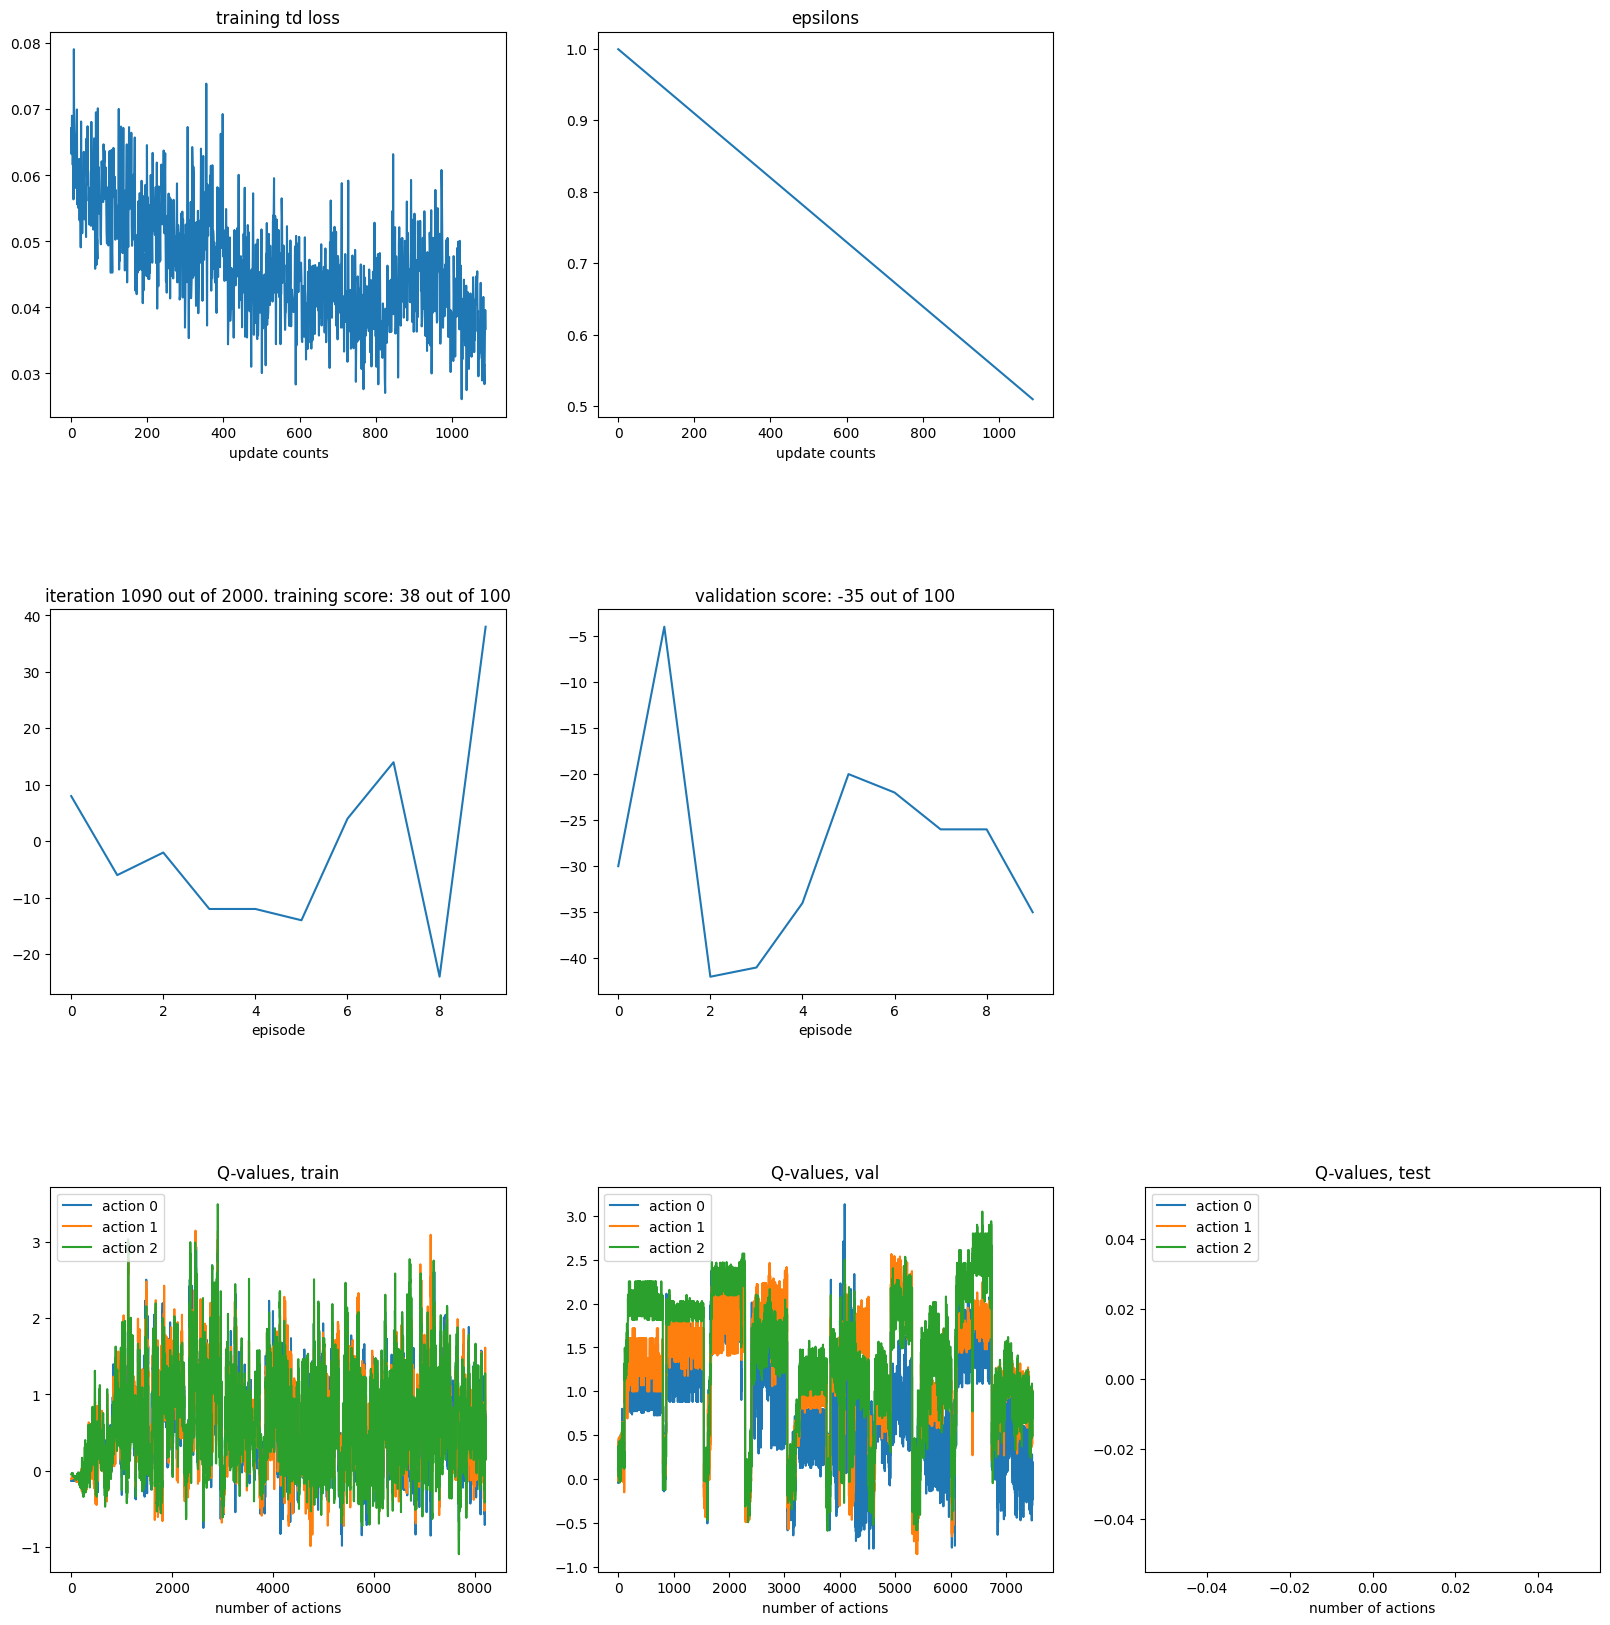

In [10]:
from agent.dqn import DQNMMAgent
import random
import logging

logger = logging.getLogger()
logger.disabled = True


config = {
    "question_prob": 1.0,
    "terminates_at": 99,
    "randomize_observations": True,
    "room_size": "m",
}

for pretrain_semantic in [False, True]:
    for test_seed in [0, 1, 2, 3, 4]:
        all_params = {
            "env_str": "room_env:RoomEnv-v2",
            "max_epsilon": 1.0,
            "min_epsilon": 0.1,
            "epsilon_decay_until": 100 * 20,
            "gamma": 0.8,
            "capacity": {
                "episodic": 32,
                "episodic_agent": 32,
                "semantic": 32,
                "short": 1,
            },
            "nn_params": {
                "hidden_size": 64,
                "num_layers": 2,
                "embedding_dim": 32,
                "v1_params": None,
                "v2_params": {},
                "memory_of_interest": [
                    "episodic",
                    "semantic",
                    "short",
                ],
            },
            "num_iterations": 100 * 20,
            "replay_buffer_size": 1024,
            "warm_start": 256,
            "batch_size": 256,
            "target_update_rate": 10,
            "pretrain_semantic": pretrain_semantic,
            "run_test": True,
            "num_samples_for_results": 10,
            "train_seed": test_seed + 5,
            "plotting_interval": 10,
            "device": "cpu",
            "test_seed": test_seed,
            "qa_policy": "episodic_semantic",
            "explore_policy": "avoid_walls",
            "env_config": config,
            "ddqn": True,
            "dueling_dqn": True,
            "split_reward_training": False,
        }

        agent = DQNMMAgent(**all_params)
        agent.train()

In [2]:
len(agent.q_values["train"]), len(
    agent.q_values["val"]), len(agent.q_values["test"])

(608, 0, 0)

In [ ]:
agent.q_values["val"][0]

In [ ]:
len(agent.q_values["train"]), len(agent.q_values["val"]), len(agent.q_values["test"])

In [ ]:
import logging

logger = logging.getLogger()
logger.disabled = True

import random

from agent.dqn import DQNExploreAgent

room_size = {
    "room_config": {
        "officeroom": {
            "north": "wall",
            "east": "wall",
            "south": "wall",
            "west": "wall",
        }
    },
    "object_transition_config": {
        "static": {"desk": None},
        "independent": {},
        "dependent": {},
        "agent": {"agent": {"officeroom": None}},
    },
    "object_init_config": {
        "static": {
            "desk": {"officeroom": 1},
        },
        "independent": {},
        "dependent": {},
        "agent": {"agent": {"officeroom": 1.0}},
    },
}
config = {
    "question_prob": 1.0,
    "seed": random.randint(0, 100000),
    "terminates_at": 9,
    "randomize_observations": False,
    "room_size": room_size,
}

for pretrain_semantic in [False]:
    for test_seed in [0]:
        all_params = {
            "env_str": "room_env:RoomEnv-v2",
            "max_epsilon": 1.0,
            "min_epsilon": 0.1,
            "epsilon_decay_until": 10 * 10,
            "gamma": 0.5,
            "capacity": {
                "episodic": 5,
                "episodic_agent": 1,
                "semantic": 1,
                "short": 1,
            },
            "nn_params": {
                "hidden_size": 64,
                "num_layers": 2,
                "embedding_dim": 32,
                "v1_params": None,
                "v2_params": {},
                "memory_of_interest": [
                    "episodic",
                    "semantic",
                    "short",
                ],
            },
            "num_iterations": 10 * 10,
            "replay_buffer_size": 128,
            "warm_start": 16,
            "batch_size": 16,
            "target_update_rate": 10,
            "pretrain_semantic": pretrain_semantic,
            "run_test": True,
            "num_samples_for_results": 10,
            "train_seed": test_seed + 5,
            "plotting_interval": 10,
            "device": "cpu",
            "test_seed": test_seed,
            "mm_policy": "episodic",
            "qa_policy": "episodic_semantic",
            "env_config": config,
            "ddqn": False,
            "dueling_dqn": False,
        }

        agent = DQNExploreAgent(**all_params)
        agent.train()

In [ ]:
len(agent.q_values["train"]), len(agent.q_values["val"]), len(agent.q_values["test"])